In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score


In [40]:
# Įkeliame normalizuotą duomenų rinkinį
df = pd.read_csv("full_dataset_NO_missing_values.csv")

print("Eilučių skaičius:", len(df))
print("Stulpeliai:", list(df.columns))


Eilučių skaičius: 11818
Stulpeliai: ['RR_l_0', 'RR_l_0/RR_l_1', 'RR_l_1', 'RR_l_1/RR_l_2', 'RR_l_2', 'RR_l_2/RR_l_3', 'RR_l_3', 'RR_l_3/RR_l_4', 'RR_r_0', 'RR_r_0/RR_r_1', 'RR_r_1', 'RR_r_1/RR_r_2', 'RR_r_2', 'RR_r_2/RR_r_3', 'RR_r_3', 'RR_r_3/RR_r_4', 'seq_size', 'signal_mean', 'signal_std', 'wl_side', 'wr_side', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val', 'P_pos', 'Q_pos', 'R_pos', 'S_pos', 'T_pos', 'label']


In [41]:
def outliers_function(data, column, factor):
    """
    Nustato išskirtis pagal IQR (Interquartile Range):
    factor = 1.5 -> sąlyginės išskirtys
    factor = 3   -> ekstremalios išskirtys
    """
    col = pd.to_numeric(data[column]).astype(float)
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    lower_15 = Q1 - 1.5 * IQR
    upper_15 = Q3 + 1.5 * IQR
    lower_3 = Q1 - 3 * IQR
    upper_3 = Q3 + 3 * IQR

    if factor == 3:
        out = col[(col < lower_3) | (col > upper_3)]
    elif factor == 1.5:
        out = col[((col < lower_15) & (col >= lower_3)) |
                  ((col > upper_15) & (col <= upper_3))]
    else:
        out = pd.Series(dtype=float)
    return out.index


In [42]:
# Aptinkame sąlygines ir ekstremalias išskirtis visose požymių reikšmėse
feature_columns = [c for c in df.columns if c != 'label']

conditional_outliers = set()
extreme_outliers = set()

for col in feature_columns:
    cond_idx = outliers_function(df, col, 1.5)
    extr_idx = outliers_function(df, col, 3)
    conditional_outliers.update(cond_idx)
    extreme_outliers.update(extr_idx)


In [43]:
# Sukuriame naują stulpelį „outlier“
df['outlier'] = df['label']

# sąlyginės išskirtys (1.5× IQR)
df.loc[df.index.isin(conditional_outliers), 'outlier'] = 3

# ekstremalios išskirtys (3× IQR)
df.loc[df.index.isin(extreme_outliers), 'outlier'] = 4

# Išvedame kiekvienos kategorijos kiekį
print(df['outlier'].value_counts())


outlier
4.0    6595
0.0    4467
3.0     612
1.0     143
2.0       1
Name: count, dtype: int64


In [44]:
# Paruošiame požymius ir klasių/išskirčių vektorius
X = df.drop(columns=['label', 'outlier']).values
y_class = df['label'].values
y_group = df['outlier'].values


In [45]:
# Nustatome hiperparametrų reikšmių kombinacijas
param_grid = {
    "perplexity": [5, 20, 30, 50],
    "learning_rate": [50, 100, 200, 400],
    "early_exaggeration": [4, 12, 24]
}

results = []

# Atliekame t-SNE ir vertiname kokybę su klasterizacija (KMeans)
for perplexity in param_grid["perplexity"]:
    for lr in param_grid["learning_rate"]:
        for exaggeration in param_grid["early_exaggeration"]:
            print(f"Testuojama: perplexity={perplexity}, lr={lr}, exaggeration={exaggeration}")

            tsne = TSNE(
                n_components=2,
                perplexity=perplexity,
                learning_rate=lr,
                early_exaggeration=exaggeration,
                n_iter=1000,
                metric="euclidean",
                init="pca",
                random_state=67
            )

            X_embedded = tsne.fit_transform(X)

            # Klasterizacija (K=3, nes trys klasės)
            kmeans = KMeans(n_clusters=3, n_init=10, random_state=67)
            labels_pred = kmeans.fit_predict(X_embedded)

            # Kokybės metrikos
            silhouette = silhouette_score(X_embedded, labels_pred)
            ch_score = calinski_harabasz_score(X_embedded, labels_pred)

            results.append({
                "perplexity": perplexity,
                "learning_rate": lr,
                "early_exaggeration": exaggeration,
                "silhouette": silhouette,
                "calinski_harabasz": ch_score
            })


Testuojama: perplexity=5, lr=50, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=50, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=50, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=100, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=100, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=100, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=200, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=200, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=200, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=400, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=400, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=5, lr=400, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=50, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=50, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=50, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=100, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=100, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=100, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=200, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=200, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=200, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=400, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=400, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=20, lr=400, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=50, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=50, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=50, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=100, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=100, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=100, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=200, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=200, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=200, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=400, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=400, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=30, lr=400, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=50, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=50, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=50, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=100, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=100, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=100, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=200, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=200, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=200, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=400, exaggeration=4


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=400, exaggeration=12


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Testuojama: perplexity=50, lr=400, exaggeration=24


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [46]:
# Surenkame visus rezultatus į DataFrame
results_df = pd.DataFrame(results)

# Surandame kombinaciją su didžiausiu Silhouette koeficientu
best = results_df.sort_values(by="silhouette", ascending=False).iloc[0]

print("\n--- Geriausi parametrai ---")
print(best)



--- Geriausi parametrai ---
perplexity               50.000000
learning_rate           400.000000
early_exaggeration       12.000000
silhouette                0.414906
calinski_harabasz     10701.893555
Name: 46, dtype: float64


In [47]:
# Paleidžiam t-SNE su optimaliomis reikšmėmis
tsne_best = TSNE(
    n_components=2,
    perplexity=best.perplexity,
    learning_rate=best.learning_rate,
    early_exaggeration=best.early_exaggeration,
    n_iter=1000,
    metric="euclidean",
    init="pca",
    random_state=67
)

X_tsne = tsne_best.fit_transform(X)


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


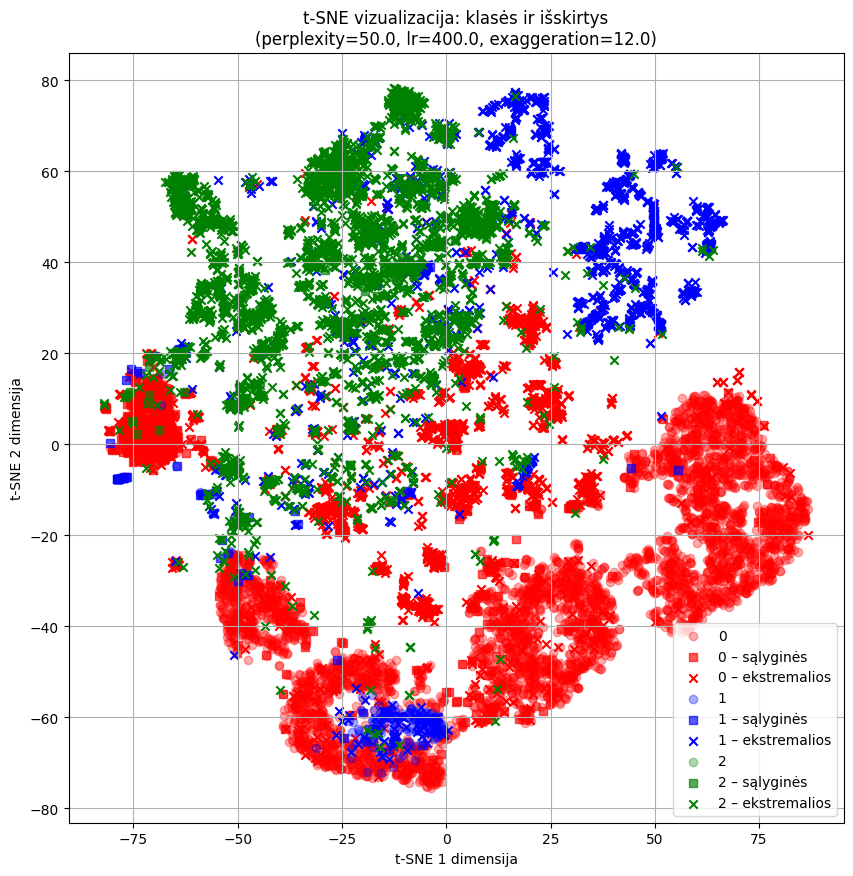

In [48]:
# Spalvos ir žymekliai pagal tavo stilių
colors = ['red', 'blue', 'green']
class_labels = ['0', '1', '2']
markers = {'normal': 'o', 'conditional': 's', 'extreme': 'x'}

plt.figure(figsize=(10, 10))

for i, color in enumerate(colors):
    # normalūs
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == i), 0],
        X_tsne[(y_class == i) & (y_group == i), 1],
        color=color,
        marker=markers['normal'],
        label=class_labels[i],
        alpha=0.33,
    )
    # sąlyginės
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == 3), 0],
        X_tsne[(y_class == i) & (y_group == 3), 1],
        color=color,
        marker=markers['conditional'],
        label=f"{class_labels[i]} – sąlyginės",
        alpha=0.66,
    )
    # ekstremalios
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == 4), 0],
        X_tsne[(y_class == i) & (y_group == 4), 1],
        color=color,
        marker=markers['extreme'],
        label=f"{class_labels[i]} – ekstremalios",
        alpha=1,
    )

plt.title(
    f"t-SNE vizualizacija: klasės ir išskirtys\n"
    f"(perplexity={best.perplexity}, lr={best.learning_rate}, exaggeration={best.early_exaggeration})"
)
plt.xlabel("t-SNE 1 dimensija")
plt.ylabel("t-SNE 2 dimensija")
plt.legend(loc="best")
plt.grid(True)
plt.show()
